# Kinematics verification

In [1]:
import sys
sys.path.append("../")

from pathlib import Path
from pyosim import Analogs3dOsim
import pandas as pd
import numpy as np
import altair as alt
alt.data_transformers.enable("json")

DataTransformerRegistry.enable('json')

## Get the data

In [2]:
DATA_PATH = Path("/home/romain/Downloads/results/mars/1_inverse_kinematic")
PREFIX = 'wu_'

### Wide form

In [3]:
data = pd.DataFrame()
for ifile in DATA_PATH.glob("*.mot"):
    x = Analogs3dOsim().from_mot(ifile).time_normalization(np.linspace(0, 100, 100))
    f = ifile.stem.replace(PREFIX, "")
    d = pd.DataFrame(x.squeeze().T, columns=x.get_2d_labels()).assign(
        filename=f,
        participant=f[:4],
        sex=f[4],
        height=f[-3],
        weight=f[5:].split("H")[0],
        trial=f[-1],
    )
    data = pd.concat([data, d.reset_index()])

In [4]:
height = {
    '1': 'hips-shoulders',
    '2': 'hips-eyes',
    '3': 'shoulders-hips',
    '4': 'shoulders-eyes',
    '5': 'eyes-hips',
    '6': 'eyes-shoulders'
}
data['height'].replace(height, inplace=True)

In [5]:
# scale data
data[x.get_2d_labels()] = data[x.get_2d_labels()].apply(lambda x: (x - np.mean(x)) / (np.max(x) - np.min(x)))

In [6]:
data.head()

index  thorax_tilt  thorax_list  thorax_rotation  thorax_tx  thorax_ty  \
0      0    -0.252689    -0.140619         0.026762   0.190722  -0.177078   
1      1    -0.308552    -0.197727         0.027608   0.227321  -0.226063   
2      2    -0.355209    -0.238546         0.028156   0.254509  -0.273065   
3      3    -0.388192    -0.260268         0.021127   0.269440  -0.308506   
4      4    -0.407497    -0.274801         0.016512   0.271206  -0.328889   

   thorax_tz  sternoclavicular_r1  sternoclavicular_r2  sternoclavicular_r3  \
0  -0.191623             0.231243            -0.129993                  NaN   
1  -0.225003             0.245083            -0.125027                  NaN   
2  -0.250499             0.245872            -0.119707                  NaN   
3  -0.262730             0.254279            -0.131075                  NaN   
4  -0.263029             0.256909            -0.114115                  NaN   

   ...    box_rotZ  box_transX  box_transY  box_transZ     filename  \
0  ...   -0.080097   -0.303075   -0.219060   -0.548113  MarSF12H2_3   
1  ...   -0.080217   -0.303141   -0.219276   -0.548103  MarSF12H2_3   
2  ...   -0.080050   -0.303793   -0.219761   -0.548215  MarSF12H2_3   
3  ...   -0.079937   -0.304992   -0.219763   -0.548326  MarSF12H2_3   
4  ...   -0.079882   -0.304640   -0.219243   -0.548322  MarSF12H2_3   

   participant  sex     height  weight  trial  
0         MarS    F  hips-eyes      12      3  
1         MarS    F  hips-eyes      12      3  
2         MarS    F  hips-eyes      12      3  
3         MarS    F  hips-eyes      12      3  
4         MarS    F  hips-eyes      12      3  

[5 rows x 32 columns]

### Long form

In [7]:
melted = data.melt(id_vars=['filename', 'participant', 'sex', 'height', 'weight', 'trial', 'index'])
melted.head()

filename participant sex     height weight trial  index     variable  \
0  MarSF12H2_3        MarS   F  hips-eyes     12     3      0  thorax_tilt   
1  MarSF12H2_3        MarS   F  hips-eyes     12     3      1  thorax_tilt   
2  MarSF12H2_3        MarS   F  hips-eyes     12     3      2  thorax_tilt   
3  MarSF12H2_3        MarS   F  hips-eyes     12     3      3  thorax_tilt   
4  MarSF12H2_3        MarS   F  hips-eyes     12     3      4  thorax_tilt   

      value  
0 -0.252689  
1 -0.308552  
2 -0.355209  
3 -0.388192  
4 -0.407497

## Add features

In [8]:
melted['abs_diff'] = melted.groupby(['filename', 'variable'])['value'].diff().abs()

In [9]:
scalar = melted.groupby(['filename', 'participant', 'sex', 'height', 'weight'])[['value', 'abs_diff']].agg(['mean', 'sum', 'std'])
scalar.columns = ["_".join(a) for a in scalar.columns.ravel()]
scalar.reset_index(inplace=True)
scalar.head()

filename participant sex          height weight  value_mean  value_sum  \
0  MarSF12H1_1        MarS   F  hips-shoulders     12   -0.022291 -53.498166   
1  MarSF12H1_2        MarS   F  hips-shoulders     12   -0.028003 -67.208076   
2  MarSF12H1_3        MarS   F  hips-shoulders     12   -0.028003 -67.208076   
3  MarSF12H2_1        MarS   F       hips-eyes     12   -0.010344 -24.824568   
4  MarSF12H2_2        MarS   F       hips-eyes     12   -0.012624 -30.296408   

   value_std  abs_diff_mean  abs_diff_sum  abs_diff_std  
0   0.197661       0.013068     31.050654      0.017566  
1   0.208154       0.009557     22.707120      0.017240  
2   0.208154       0.009557     22.707120      0.017240  
3   0.210988       0.011719     27.844523      0.013666  
4   0.233263       0.013811     32.814594      0.013689

In [10]:
scalar = scalar.join(
    scalar[
        [
            "value_mean",
            "value_sum",
            "value_std",
            "abs_diff_mean",
            "abs_diff_sum",
            "abs_diff_std",
        ]
    ]
    .apply(lambda x: np.sqrt((x - x.mean()) ** 2))
    .rename(columns=lambda x: f"dev_{x}")
)

## Visualization

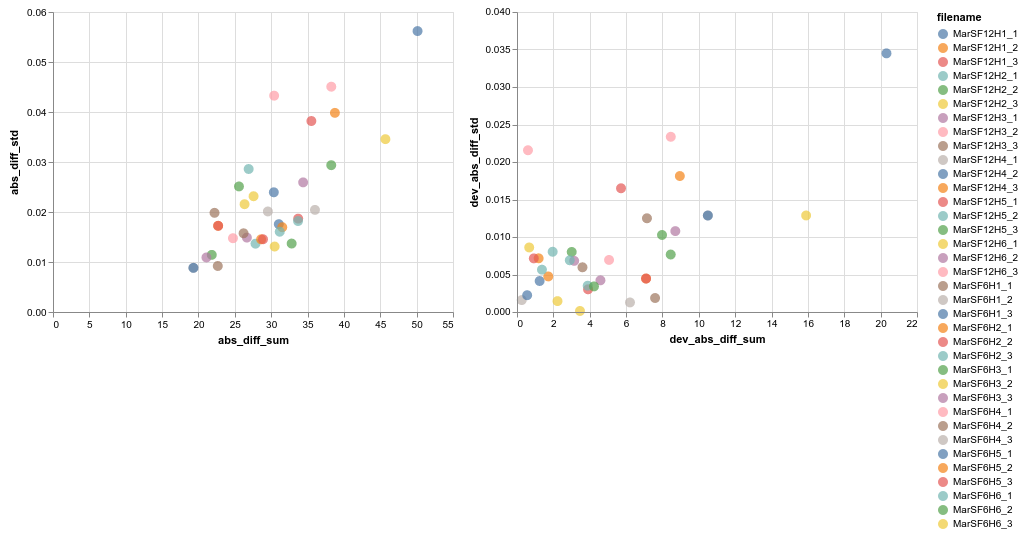

In [15]:
brush = alt.selection(type="interval", resolve="global")

base = (
    alt.Chart(scalar).encode(
        tooltip="filename",
        color=alt.condition(brush, "filename", alt.value("lightgray")),
    )
).add_selection(brush)

chart_diff = base.mark_circle(size=100).encode(x="abs_diff_sum", y="abs_diff_std")
chart_dev_diff = base.mark_circle(size=100).encode(x="dev_abs_diff_sum", y="dev_abs_diff_std")

chart_diff | chart_dev_diff

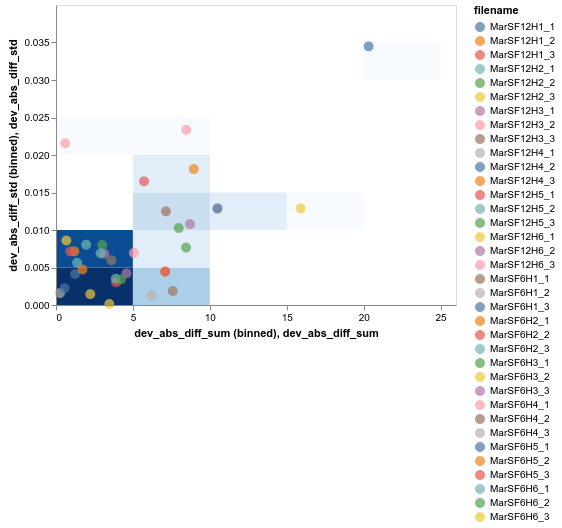

In [12]:
heat_dev_diff = (
    alt.Chart(scalar)
    .mark_rect()
    .encode(
        alt.X("dev_abs_diff_sum", bin=alt.Bin(maxbins=10)),
        alt.Y("dev_abs_diff_std", bin=alt.Bin(maxbins=10)),
        alt.Color(
            "count(dev_abs_diff_std)", scale=alt.Scale(scheme="blues"), legend=None
        ),
    )
)

heat_dev_diff + chart_dev_diff

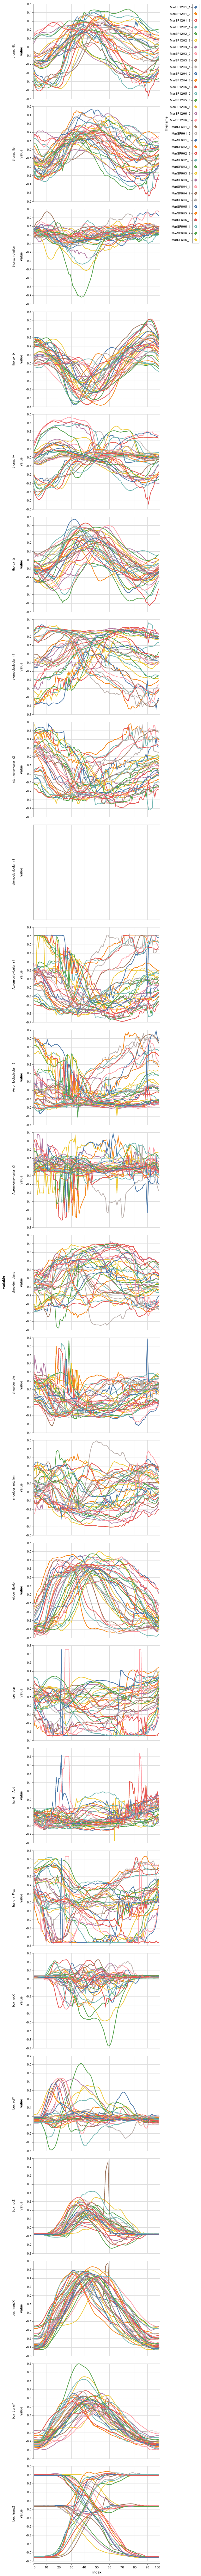

In [13]:
click = alt.selection_multi(encodings=["color"])

chart = (
    alt.Chart(melted)
    .mark_line()
    .encode(
        x="index",
        y="value",
        detail="filename",
        tooltip="filename",
        color=alt.condition(click, "filename", alt.value("lightgray"), legend=None),
    )
    .properties(selection=click)
    .facet(alt.Row("variable", sort=alt.Sort(x.get_2d_labels())))
    .resolve_scale(y="independent")
)

legend = (
    alt.Chart(melted)
    .mark_point()
    .encode(
        y="filename",
        color=alt.condition(click, "filename", alt.value("lightgray"), legend=None),
    )
).properties(selection=click)

(chart | legend)